# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [1]:
#you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/My Drive/assignment3_starter_sp24"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/assignment3_starter_sp24" $datadir # TODO: Fill your Assignment 3 path
os.chdir(datadir)
!pwd

/content/drive/My Drive/assignment3_starter_sp24


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__getitem__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    elif rot == 1:
        return torch.rot90(img, k=1, dims=(1, 2))
    elif rot == 2:
        return torch.rot90(img, k=2, dims=(1, 2))
    elif rot == 3:
        return torch.rot90(img, k=3, dims=(1, 2))
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')




class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Show some example images and rotated images with labels:

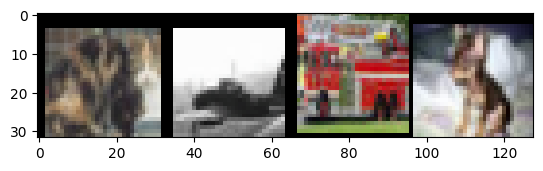

Class labels:  cat   plane truck dog  


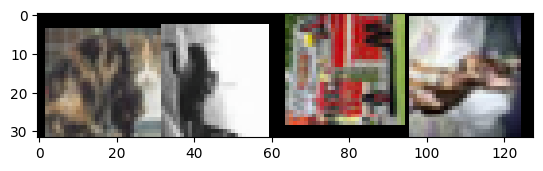

Rotation labels:  0     270   90    270  


In [5]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [6]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [7]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

### In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [10]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001)

In [11]:
def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # Set the data to the correct device; Different tasks will use different inputs and labels
            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)

            print_freq = 100
            running_loss += loss.item()

            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        net.eval()
        run_test(net, testloader, criterion, task)



In [ ]:
train(net, criterion, optimizer, num_epochs=70, decay_epochs=10, init_lr=0.02, task='rotation')

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

[1,   100] loss: 1.570 acc: 43.68 time: 7.32
[1,   200] loss: 1.019 acc: 55.96 time: 6.90
[1,   300] loss: 0.945 acc: 59.36 time: 7.74
TESTING:
Accuracy of the network on the 10000 test images: 63.15 %
Average loss on the 10000 test images: 0.939
[2,   100] loss: 0.866 acc: 63.02 time: 7.76
[2,   200] loss: 0.849 acc: 64.16 time: 6.33
[2,   300] loss: 0.804 acc: 66.48 time: 7.68
TESTING:
Accuracy of the network on the 10000 test images: 68.47 %
Average loss on the 10000 test images: 0.761
[3,   100] loss: 0.773 acc: 67.59 time: 6.50
[3,   200] loss: 0.757 acc: 68.66 time: 7.56
[3,   300] loss: 0.755 acc: 68.98 time: 6.36
TESTING:
Accuracy of the network on the 10000 test images: 71.40 %
Average loss on the 10000 test images: 0.695
[4,   100] loss: 0.726 acc: 70.29 time: 7.24
[4,   200] loss: 0.726 acc: 70.23 time: 6.76
[4,   300] loss: 0.698 acc: 71.55 time: 6.95
TESTING:
Accuracy of the network on the 10000 test images: 73.21 %
Average loss on the 10000 test images: 0.658
[5,   100] l

# Fine-tuning on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
!export CUDA_LAUNCH_BLOCKING=1
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu118



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [12]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
net = resnet18(pretrained=True)

net = net.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


In [13]:
for name, param in net.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False




In [14]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [15]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [16]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 1.833 acc: 43.73 time: 7.63
[1,   200] loss: 1.355 acc: 54.35 time: 6.27
[1,   300] loss: 1.244 acc: 58.04 time: 5.89
TESTING:
Accuracy of the network on the 10000 test images: 62.16 %
Average loss on the 10000 test images: 1.078
[2,   100] loss: 1.138 acc: 60.77 time: 5.81
[2,   200] loss: 1.096 acc: 62.17 time: 5.85
[2,   300] loss: 1.084 acc: 62.16 time: 6.98
TESTING:
Accuracy of the network on the 10000 test images: 65.10 %
Average loss on the 10000 test images: 1.006
[3,   100] loss: 1.061 acc: 63.25 time: 5.73
[3,   200] loss: 1.046 acc: 63.73 time: 6.39
[3,   300] loss: 1.011 acc: 65.21 time: 6.05
TESTING:
Accuracy of the network on the 10000 test images: 66.27 %
Average loss on the 10000 test images: 0.967
[4,   100] loss: 1.012 acc: 64.48 time: 6.44
[4,   200] loss: 0.997 acc: 65.37 time: 6.46
[4,   300] loss: 0.981 acc: 65.47 time: 6.10
TESTING:
Accuracy of the network on the 10000 test images: 66.62 %
Average loss on the 10000 test images: 0.955
[5,   100] l

# Fine-tuning on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

resnet = resnet18()
for param in resnet.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [18]:
for name, param in net.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


In [19]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [20]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [21]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 0.706 acc: 75.32 time: 5.91
[1,   200] loss: 0.720 acc: 74.50 time: 6.98
[1,   300] loss: 0.710 acc: 74.84 time: 5.67
TESTING:
Accuracy of the network on the 10000 test images: 71.99 %
Average loss on the 10000 test images: 0.821
[2,   100] loss: 0.712 acc: 74.52 time: 6.12
[2,   200] loss: 0.698 acc: 75.28 time: 6.61
[2,   300] loss: 0.715 acc: 74.53 time: 5.59
TESTING:
Accuracy of the network on the 10000 test images: 71.49 %
Average loss on the 10000 test images: 0.822
[3,   100] loss: 0.713 acc: 74.62 time: 7.18
[3,   200] loss: 0.698 acc: 75.11 time: 5.82
[3,   300] loss: 0.719 acc: 74.12 time: 6.28
TESTING:
Accuracy of the network on the 10000 test images: 72.01 %
Average loss on the 10000 test images: 0.817
[4,   100] loss: 0.714 acc: 74.63 time: 7.14
[4,   200] loss: 0.701 acc: 75.00 time: 5.65
[4,   300] loss: 0.704 acc: 75.16 time: 6.59
TESTING:
Accuracy of the network on the 10000 test images: 71.70 %
Average loss on the 10000 test images: 0.824
[5,   100] l

# Supervised training on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(pretrained=True)
net = net.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 0.448 acc: 84.00 time: 7.96
[1,   200] loss: 0.477 acc: 83.46 time: 6.47
[1,   300] loss: 0.456 acc: 83.95 time: 7.73
TESTING:
Accuracy of the network on the 10000 test images: 82.13 %
Average loss on the 10000 test images: 0.525
[2,   100] loss: 0.448 acc: 84.43 time: 6.80
[2,   200] loss: 0.463 acc: 83.96 time: 7.65
[2,   300] loss: 0.461 acc: 83.82 time: 6.30
TESTING:
Accuracy of the network on the 10000 test images: 82.11 %
Average loss on the 10000 test images: 0.525
[3,   100] loss: 0.455 acc: 84.41 time: 6.74
[3,   200] loss: 0.462 acc: 83.86 time: 7.76
[3,   300] loss: 0.475 acc: 83.49 time: 6.80
TESTING:
Accuracy of the network on the 10000 test images: 82.06 %
Average loss on the 10000 test images: 0.523
[4,   100] loss: 0.450 acc: 84.10 time: 7.94
[4,   200] loss: 0.460 acc: 84.01 time: 6.40
[4,   300] loss: 0.474 acc: 83.81 time: 7.91
TESTING:
Accuracy of the network on the 10000 test images: 82.15 %
Average loss on the 10000 test images: 0.525
[5,   100] l

# Supervised training on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

resnet = resnet18()
for param in resnet.parameters():
    nn.init.normal_(param, mean=0, std=0.01)



In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 0.471 acc: 83.48 time: 6.54
[1,   200] loss: 0.459 acc: 83.88 time: 7.86
[1,   300] loss: 0.451 acc: 84.38 time: 6.34
TESTING:
Accuracy of the network on the 10000 test images: 82.21 %
Average loss on the 10000 test images: 0.524
[2,   100] loss: 0.468 acc: 83.58 time: 6.55
[2,   200] loss: 0.453 acc: 84.52 time: 8.07
[2,   300] loss: 0.465 acc: 83.54 time: 6.73
TESTING:
Accuracy of the network on the 10000 test images: 82.25 %
Average loss on the 10000 test images: 0.523
[3,   100] loss: 0.458 acc: 84.28 time: 7.93
[3,   200] loss: 0.455 acc: 84.27 time: 6.44
[3,   300] loss: 0.465 acc: 83.80 time: 7.64
TESTING:
Accuracy of the network on the 10000 test images: 82.11 %
Average loss on the 10000 test images: 0.523
[4,   100] loss: 0.449 acc: 84.44 time: 7.25
[4,   200] loss: 0.464 acc: 83.69 time: 7.30
[4,   300] loss: 0.456 acc: 83.98 time: 6.78
TESTING:
Accuracy of the network on the 10000 test images: 82.09 %
Average loss on the 10000 test images: 0.521
[5,   100] l